In [4]:
import glob
from skimage import io
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from image_funcs import *
import skimage
import peakutils
import cv2
from tqdm import tqdm  
import imageio
import re
import os
import time
from pystackreg import StackReg
from skimage.util import img_as_uint

In [2]:
directory = "/home/georgeosh/lvm_super_cluster/Dropbox (Cambridge University)/DATA_Bakshi_PaulssonLab/ND2_extracted/40x_Ph2_testData_TIFFs/40x_Ph2_Test_1_5_TIFFs/"
phase_channel = "BF"
other_channels = ["RFP"]
def get_FOVs(directory, channel, padding):
    channel = channel
    z = 0
    FOV = "xy{}".format(str(z).zfill(padding))
    while len(images := glob.glob(directory + "{}**{}.tif".format(FOV,channel))) > 0:
        FOV = "xy{}".format(str(z).zfill(padding))
        z += 1
    num_FOVs = z-1
    
    FOVs = []
    for x in range(num_FOVs):
        FOVs.append("xy{}".format(str(x).zfill(padding)))
    
    return FOVs

def get_image_list(directory,FOV, channel):
    images =  glob.glob(directory + "{}**{}.tif".format(FOV,channel)) 
    images.sort()
    return images

def drift_correct_images(image_list, bit_size = np.uint16):
    ref = io.imread(image_list[0])
    drift_corrected_images = Parallel(n_jobs=-1)(delayed(correct_drift)(ref, io.imread(image_list[i])) for i in tqdm(range(len(image_list))))
    all_images = [drift_corrected_images[x][0].astype(bit_size) for x in range(len(drift_corrected_images))]
    trans_matrices = [drift_corrected_images[x][1] for x in range(len(drift_corrected_images))]
    return all_images, trans_matrices


def image_splitter(images):
    top_half_images = []
    bottom_half_images = []
    for i in range(len(images)):
        top_half_images.append(get_img_half(images[i],"top"))
        bottom_half_images.append(get_img_half(images[i],"bottom"))
    return top_half_images, bottom_half_images




In [3]:
def save_image(image_directory, frame):
    cv2.imwrite(image_directory, frame, [cv2.IMWRITE_TIFF_COMPRESSION, 1])

def register_transform_save_FOV(directory, FOV, phase_channel, fluor_channels):
    img_directories = get_image_list(directory,FOV, phase_channel)
    images, trans_matrices = drift_correct_images(img_directories)
    Parallel(n_jobs=-1)(delayed(save_image)(directory, image) for directory, image in tqdm(zip(img_directories, images), total = len(img_directories), desc = "Writing phase contrast FOV {} to disk".format(FOV), leave = False))
    for fluor_channel in fluor_channels:
        img_directories = get_image_list(directory,FOV, fluor_channel)
        images = []
        for x in range(len(img_directories)):
            images.append(io.imread(img_directories[x]))
        sr = StackReg(StackReg.RIGID_BODY)
        images = Parallel(n_jobs=-1)(  delayed(  sr.transform  )(image, trans_matrix) for image, trans_matrix in tqdm(zip(images, trans_matrices), total = len(images), desc = "Transforming FL channel {} in FOV {}".format(fluor_channel, FOV), leave = False))
        for x in range(len(images)):
            images[x] = images[x].astype(np.uint16)
        Parallel(n_jobs=-1)(delayed(save_image)(directory, image) for directory, image in tqdm(zip(img_directories, images), total = len(images), desc = "Writing FL channel {} images in FOV {} to disk".format(fluor_channel, FOV), leave = False))

In [5]:
for 
register_transform_save_FOV(directory, "xy002", "BF", ["RFP"])

100%|██████████| 25/25 [00:13<00:00,  1.88it/s]
Writing FL channel RFP images in FOV xy002 to disk:   0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
start = time.time()
for directory, image in zip(img_directories, images):
    save_image(directory, image)
end = time.time()
print(end-start)labeled, num_regions  = mh.label(dilated)
    sizes = mh.labeled.labeled_size(labeled)
    mh.labeled.labeled_size(labeled)

61.93037033081055


In [25]:
start = time.time()
Parallel(n_jobs=10)(delayed(save_image)(directory, image) for directory, image in zip(img_directories, images))
end = time.time()
print(end - start)

37.30284595489502


In [ ]:
for y in range(len(midpoints)-1):
    cropped = fixed_image[top_threshold_line:bottom_threshold_line,int(midpoints[y]):int(midpoints[y+1])]
    try:
        os.mkdir("folder_org/trench_{}".format(str(y).zfill(2)))
    except:
        pass
    for x in range(len(all_images)):
        fixed_image = all_images[x]
        rescaled = (255.0 / cropped.max() * (cropped - cropped.min())).astype(np.uint8)
        imageio.imwrite("folder_org/trench_{}/".format(str(y).zfill(2)) + str(re.findall("T(\d+)", images[x])[0]).zfill(4)  + '.png',rescaled)

In [84]:
FOVs = get_FOVs(directory, "BF", 3)
a = 0
for FOV in FOVs:
    initial_image = get_image_list(directory,FOV, "BF")[0]
    image = io.imread(initial_image)
    if a == 0:
        rotation = get_orientation(image, debug = False)
    fixed_image = fix_orientation(image, rotation)
    fixed_image = img_as_uint(fixed_image)
    cv2.imwrite("diagnostics/rotations/{}.tif".format(FOV), fixed_image, [cv2.IMWRITE_TIFF_COMPRESSION, 1])
    top_half, bottom_half = get_img_half(image,"top"), get_img_half(image,"bottom")
    bottom_half = img_as_uint(skimage.transform.rotate(bottom_half, 180))
    cv2.imwrite("diagnostics/top_split/{}.tif".format(FOV), top_half, [cv2.IMWRITE_TIFF_COMPRESSION, 1])
    cv2.imwrite("diagnostics/bottom_split/{}.tif".format(FOV), bottom_half, [cv2.IMWRITE_TIFF_COMPRESSION, 1])
    a +=1
#fixed_image = fix_orientation(all_images[0], rotation)



In [55]:
image_splitter([image])[0][0]

array([[546, 529, 575, ..., 745, 739, 672],
       [582, 528, 549, ..., 624, 634, 643],
       [590, 564, 611, ..., 623, 722, 609],
       ...,
       [868, 811, 743, ..., 764, 694, 725],
       [937, 874, 822, ..., 786, 793, 818],
       [858, 821, 877, ..., 814, 746, 771]], dtype=uint16)

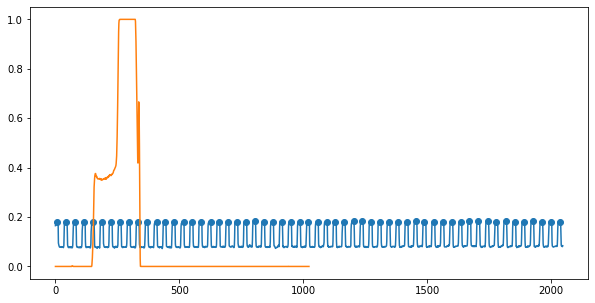

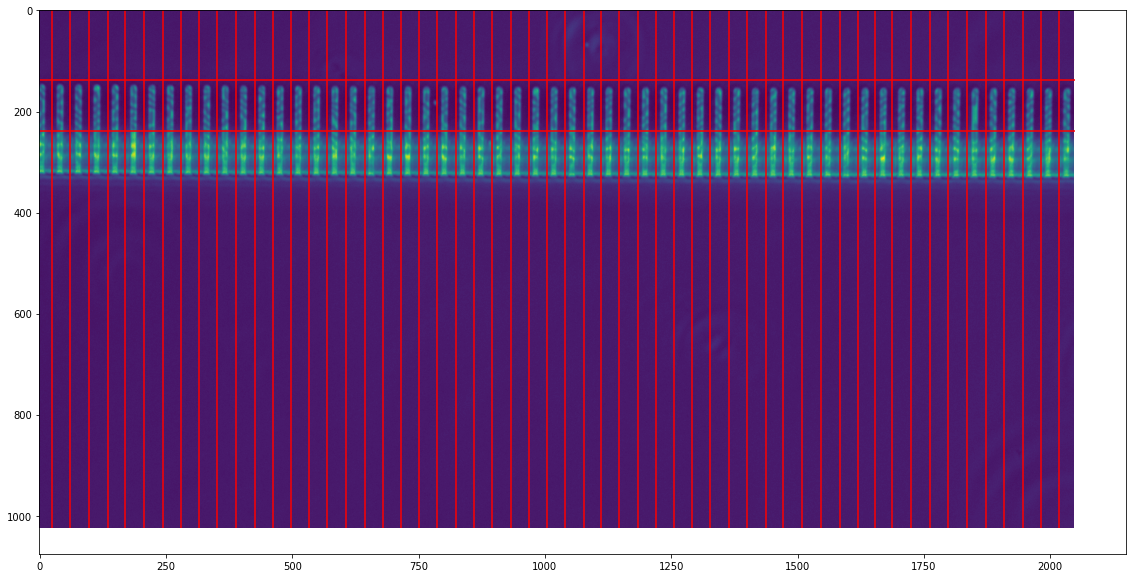

In [82]:
rotation = 0

test_image = img_as_uint(skimage.transform.rotate(bottom_half, 180))



bin_image = test_image > threshold_li(test_image) * 1
x_mean_intensity = np.mean(bin_image, axis=0)
y_mean_intensity = np.mean(bin_image, axis=1)
indexes = peakutils.indexes(x_mean_intensity, thres=1.4*np.mean(x_mean_intensity), min_dist=20)

midpoints = (indexes[1:] + indexes[:-1]) / 2
rotation = get_orientation(image)

f, ax = plt.subplots(figsize=(10,5))
plt.plot(x_mean_intensity)
plt.plot(y_mean_intensity)
plt.scatter(indexes, x_mean_intensity[indexes])

midpoints = (indexes[1:] + indexes[:-1]) / 2
rotation = get_orientation(image)
fixed_image = test_image

top_threshold = np.mean(y_mean_intensity)/20
bottom_threshold = np.max(y_mean_intensity)/2
top_threshold_line = np.argmax(y_mean_intensity > top_threshold) - 10
bottom_threshold_line = np.argmax(y_mean_intensity > bottom_threshold)-10

f, ax = plt.subplots(figsize=(20,10))
plt.imshow(test_image)
plt.vlines(midpoints, ymin = 0, ymax = fixed_image.shape[0], color="r")
plt.hlines(top_threshold_line, xmin = 0, xmax = fixed_image.shape[1], color="r")
plt.hlines(bottom_threshold_line, xmin = 0, xmax = 2048, color="r")


array([[756, 747, 774, ..., 690, 830, 792],
       [763, 757, 756, ..., 817, 765, 781],
       [783, 662, 738, ..., 827, 804, 822],
       ...,
       [760, 786, 815, ..., 825, 855, 905],
       [735, 774, 792, ..., 869, 847, 802],
       [795, 719, 782, ..., 919, 828, 929]], dtype=uint16)

In [79]:
bottom_half

array([[929, 828, 919, ..., 782, 719, 795],
       [802, 847, 869, ..., 792, 774, 735],
       [905, 855, 825, ..., 815, 786, 760],
       ...,
       [822, 804, 827, ..., 738, 662, 783],
       [781, 765, 817, ..., 756, 757, 763],
       [792, 830, 690, ..., 774, 747, 756]], dtype=uint16)